In [64]:
#Importa librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import scipy.stats as stats





DATA COLLECTION

Datos de Yahoo Finance

In [65]:
sp500 = yf.Ticker("^GSPC")
gold = yf.Ticker("^GC=F")
oil= yf.Ticker("CL=F")
brent= yf.Ticker("BZ=F")

Gold no existe. El ticker no baja ninguna información. Lo sustituyo por la volatilidad del mercado de oro que se descarga de los datos de la FED de St. Louis.

Para el Sp500 utilizo los datos a partir del año 2000, ya que en años anteriores la composición por industria del SP500 era bastante diferente. A partir de ese año hay importnate participación del sector teconología. Hago lo mismo para las otras variables

In [66]:
start_date = '2000-01-01'
end_date = '2024-04-26'

sp500 = sp500.history(period="max")
sp500 =sp500.loc[start_date:end_date].copy ()
oil = oil.history(period="max")
oil = oil.loc[start_date:end_date].copy ()
brent = brent.history(period="max") 
brent = brent.loc[start_date:end_date:].copy ()


In [67]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


In [68]:
sp500 = sp500.drop(columns=['Dividends', 'Stock Splits'])
sp500.index= sp500.index.tz_localize(None) # remove timezone porque tengo otras variables que no la tienen. para uniformar

In [69]:
#Guardar el dataset en un archivo csv   
sp500.to_csv('sp500.csv', index=True)

In [70]:
#Hago lo mismo con el resto de los activos
oil = oil.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
oil.index= oil.index.tz_localize(None) # remove timezone
oil.head()

,Close
Date,
2000-08-23,32.049999
2000-08-24,31.629999
2000-08-25,32.049999
2000-08-28,32.869999
2000-08-29,32.720001


In [71]:
# Renombro la columna 'Close' a 'Close_oil' en el DataFrame 'oil' para que no se confunda con la del S&P 500
oil.rename(columns={'Close': 'Close_oil'}, inplace=True)

# Muestra las primeras filas para verificar el cambio
print(oil.head())


            Close_oil
Date                 
2000-08-23  32.049999
2000-08-24  31.629999
2000-08-25  32.049999
2000-08-28  32.869999
2000-08-29  32.720001


In [72]:
# Asumiendo que 'df' es tu DataFrame y 'oil' es la columna con los datos de precios de petróleo, saco los cambios diarios en el precio del oil.
oil['oil_daily_changes'] = oil['Close_oil'].pct_change() * 100  # Multiplicar por 100 para convertir a porcentaje


Calculo de las variables para análisis técnico (variables calculadas a partir de los precios de los activos). Ayudan a la toma de decisiones al dar información sobre el comportamiento de cada activo a través del tiempo.
Buscan determinar tendencias en los precios.

In [89]:
#Calculo la media 
# Periodos para las medias móviles
moving_avg_periods = [5,10, 20,200]

# Calcular y asignar cada media móvil utilizando un bucle
for period in moving_avg_periods:
    sp500[f'{period}d_moving_avg'] = sp500['Close'].rolling(window=period).mean()

# Mostrar las primeras filas para verificar las nuevas columnas
sp500.head()



,Open,High,Low,Close,Volume,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,NaN,NaN,NaN,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,NaN,NaN,NaN,NaN
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,NaN,NaN,NaN,NaN
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,NaN,NaN,NaN,NaN
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,1420.333984,NaN,NaN,NaN


In [90]:
#Calculo el promedio móvil ponderado de los ultimas 2 semanas

# Definimos los pesos decrecientes para los últimos 10 días hábiles.
weights = np.arange(1, 11)[::-1]  # Esto crea un array de numpy: [10, 9, ..., 2, 1]

# Calculamos el WMA para cada ventana de 10 días hábiles.
# Usamos apply para aplicar una función personalizada que calcula el WMA de manera vectorizada.
sp500['10d_wma'] = sp500['Close'].rolling(window=10).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Ahora, el DataFrame 'sp500' contiene una nueva columna '10d_wma' con el WMA de 10 días.
# Muestra los primeros registros para verificar.
print(sp500[['Close', '10d_wma']].head(20))


                  Close      10d_wma
Date                                
2000-01-03  1455.219971          NaN
2000-01-04  1399.420044          NaN
2000-01-05  1402.109985          NaN
2000-01-06  1403.449951          NaN
2000-01-07  1441.469971          NaN
2000-01-10  1457.599976          NaN
2000-01-11  1438.560059          NaN
2000-01-12  1432.250000          NaN
2000-01-13  1449.680054          NaN
2000-01-14  1465.150024  1428.005995
2000-01-18  1455.140015  1424.235638
2000-01-19  1455.900024  1431.637631
2000-01-20  1445.569946  1439.340725
2000-01-21  1441.359985  1447.489462
2000-01-24  1401.530029  1447.999288
2000-01-25  1410.030029  1444.711477
2000-01-26  1404.089966  1444.258740
2000-01-27  1398.560059  1444.340743
2000-01-28  1360.160034  1439.626008
2000-01-31  1394.459961  1430.813277


In [91]:
# Calcular el momentum como el cambio día a día en la columna 'Close'. Es lo mismo que el daily change pero en absoluto no porcentual
sp500['Momentum'] = sp500['Close'].diff()

print(sp500.head())  # Mostrar las primeras filas para verificar la nueva columna

                   Open         High          Low        Close      Volume  \
Date                                                                         
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971   931800000   
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1009000000   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1085500000   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1092300000   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1225200000   

            5d_moving_avg  10d_moving_avg  20d_moving_avg  200d_moving_avg  \
Date                                                                         
2000-01-03            NaN             NaN             NaN              NaN   
2000-01-04            NaN             NaN             NaN              NaN   
2000-01-05            NaN             NaN             NaN              NaN   
2000-01-06            NaN             NaN             NaN      

El Stochastic %K es una medida de la posición relativa del precio de cierre actual en relación con el rango alto-bajo durante un número específico de períodos pasados. La fórmula para calcular el Stochastic %K es la siguiente:

% K = [(C-LLn)/(HHn-LLn)]x 100� 

donde:


C es el precio de cierre más reciente,

LLn es el precio más bajo de los prcios bajos (Low) en los últimos n períodos,
Hn  es el precio más alto de lso pecios altos (High) en los últimos n períodos,
n es el número de períodos utilizados para el cálculo.
El valor de n varía según el análisis, pero los valores comunes incluyen 14, 20 o cualquier otro valor dependiendo de la estrategia de trading

In [92]:
# Calcular el Stochastic %K para cada fila basado en los 20 días laborables previos
# Crear una función para encapsular el cálculo
#def calculate_stochastic_k(row_index, df):
    #if row_index < 19:  # Asegurar que haya suficientes datos para los primeros 19 registros
        #return None
    #else:
        #period = df['Close'][row_index-19:row_index+1]  # Seleccionar los últimos 20 registros hasta el índice actual
        #low_20 = period.min()
        #high_20 = period.max()
        #close_recent = df['Close'].iloc[row_index]
        #stochastic_k = ((close_recent - low_20) / (high_20 - low_20)) * 100
        #return stochastic_k

# Aplicar la función a cada fila
# Nota: Esto puede ser lento para DataFrames muy grandes debido al enfoque iterativo
#sp500['Stochastic_%K'] = [calculate_stochastic_k(i, sp500) for i in range(len(sp500))]

#print(sp500.tail())  # Mostrar las últimas filas para verificar la nueva columna
#sp500.head


# Crear una función para encapsular el cálculo del Stochastic %K
def calculate_stochastic_k(row_index, df):
    if row_index < 19:  # Asegurar que haya suficientes datos para los primeros 19 registros
        return None
    else:
        # Seleccionar los últimos 20 registros hasta el índice actual para las columnas 'High' y 'Low'
        high_period = df['High'][row_index-19:row_index+1]
        low_period = df['Low'][row_index-19:row_index+1]
        low_20 = low_period.min()
        high_20 = high_period.max()
        close_recent = df['Close'].iloc[row_index]
        
        # Calcular el Stochastic %K
        stochastic_k = ((close_recent - low_20) / (high_20 - low_20)) * 100
        return stochastic_k

# Aplicar la función a cada fila
sp500['Stochastic_%K'] = [calculate_stochastic_k(i, sp500) for i in range(len(sp500))]

# Mostrar las últimas filas para verificar la nueva columna
print(sp500.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-22  4987.330078  5038.839844  4969.399902  5010.600098  3820250000   
2024-04-23  5028.850098  5076.120117  5027.959961  5070.549805  3751400000   
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   

            5d_moving_avg  10d_moving_avg  20d_moving_avg  200d_moving_avg  \
Date                                                                         
2024-04-22    5012.514063     5081.741064     5147.851562      4677.076304   
2024-04-23    5016.341992     5067.805029     5140.469556      4680.434302   
2024-04-24    5026.225977     5058.904004     5133.872046      4683.744802   
2024-04-25    5033.685938     5043.839990     5123.868530      

El indicador Stochastic %D es una media móvil del indicador Stochastic %K. Usualmente se calcula como la media móvil simple de los últimos 3 valores de %K. Para calcular el %D para las últimas 20 observaciones de tu DataFrame sp500, primero necesitaríamos calcular el %K como se discutió anteriormente, y luego aplicar una media móvil sobre esos valores de %K.

In [93]:

# Calcular el Stochastic %D como la media móvil simple de 3 días de %K
sp500['Stochastic_%D'] = sp500['Stochastic_%K'].rolling(window=3).mean()

# Si solo necesitas las últimas 20 observaciones para el %D, puedes hacer lo siguiente:
last_20_stochastic_D = sp500['Stochastic_%D'][-20:]

print(last_20_stochastic_D)
sp500.head(9)

Date
2024-04-01    92.882218
2024-04-02    85.479659
2024-04-03    76.922842
2024-04-04    57.726515
2024-04-05    55.575326
2024-04-08    53.829101
2024-04-09    64.992990
2024-04-10    54.961573
2024-04-11    53.283501
2024-04-12    35.318808
2024-04-15    25.095684
2024-04-16     7.141325
2024-04-17     5.118661
2024-04-18     4.821237
2024-04-19     4.569616
2024-04-22     8.741723
2024-04-23    20.099123
2024-04-24    31.278398
2024-04-25    35.328193
2024-04-26    38.522920
Name: Stochastic_%D, dtype: float64


,Open,High,Low,Close,Volume,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D
Date,,,,,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,NaN,NaN,NaN,NaN,NaN,-55.799927,NaN,NaN
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,NaN,NaN,NaN,NaN,NaN,2.689941,NaN,NaN
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,NaN,NaN,NaN,NaN,NaN,1.339966,NaN,NaN
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,1420.333984,NaN,NaN,NaN,NaN,38.020020,NaN,NaN
2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1064800000,1420.809985,NaN,NaN,NaN,NaN,16.130005,NaN,NaN
2000-01-11,1457.599976,1458.660034,1434.420044,1438.560059,1014000000,1428.637988,NaN,NaN,NaN,NaN,-19.039917,NaN,NaN
2000-01-12,1438.560059,1442.599976,1427.079956,1432.250000,974600000,1434.665991,NaN,NaN,NaN,NaN,-6.310059,NaN,NaN
2000-01-13,1432.250000,1454.199951,1432.250000,1449.680054,1030400000,1443.912012,NaN,NaN,NaN,NaN,17.430054,NaN,NaN



El Índice de Fuerza Relativa (RSI, por sus siglas en inglés) es un indicador de momento que mide la magnitud de los movimientos recientes de precios para evaluar condiciones de sobrecompra o sobreventa en el precio de un activo. Se calcula utilizando la fórmula:

RSI=100− 100/(1+RS)
 

donde 
�
�
RS es la relación media de días de cierre hacia arriba entre la media de días de cierre hacia abajo. Para calcularlo para los últimos 20 y 10 días, necesitamos seguir los siguientes pasos para cada ventana de tiempo:

Calcular los cambios diarios en el precio de cierre.
Separar estos cambios en ganancias (aumentos) y pérdidas (disminuciones).
Calcular el promedio de ganancias y el promedio de pérdidas sobre el período de interés (20 días y 10 días, respectivamente).
Calcular el RS, que es el promedio de ganancias dividido por el promedio de pérdidas.
Utilizar la fórmula del RSI para obtener el valor final.

In [94]:
# Separar las ganancias (positivas) de las pérdidas (negativas)
gain = sp500['Momentum'].mask(sp500['Momentum'] > 0, 0)
loss = -sp500['Momentum'].mask(sp500['Momentum'] < 0, 0)

# Calcular el RSI para los últimos 20 y 10 días
window_lengths = [20, 10]

for length in window_lengths:
    # Calcular el promedio de ganancias y pérdidas
    avg_gain = gain.rolling(window=length, min_periods=1).mean()
    avg_loss = loss.rolling(window=length, min_periods=1).mean()
    
    # Calcular RS
    rs = avg_gain / avg_loss
    
    # Calcular RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Adjuntar al DataFrame
    sp500[f'RSI_{length}'] = rsi

# Mostrar las últimas 20 filas para verificar las nuevas columnas
print(sp500.tail(20))



                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-01  5257.970215  5263.950195  5229.200195  5243.770020  3325930000   
2024-04-02  5204.290039  5208.339844  5184.049805  5205.810059  3886590000   
2024-04-03  5194.370117  5228.750000  5194.370117  5211.490234  3703250000   
2024-04-04  5244.049805  5256.589844  5146.060059  5147.209961  4075680000   
2024-04-05  5158.950195  5222.180176  5157.209961  5204.339844  3386780000   
2024-04-08  5211.370117  5219.569824  5197.350098  5202.390137  3278180000   
2024-04-09  5217.029785  5224.810059  5160.779785  5209.910156  3400680000   
2024-04-10  5167.879883  5178.430176  5138.700195  5160.640137  3845930000   
2024-04-11  5172.950195  5211.779785  5138.770020  5199.060059  3509380000   
2024-04-12  5171.509766  5175.029785  5107.939941  5123.410156  3963220000   
2024-04-15  5149.669922  5168.430176  5052.470215  5061.819824  


El indicador Larry Williams %R es una medida de momentum que se utiliza para identificar niveles de sobrecompra y sobreventa en un mercado. Se calcula como un porcentaje que refleja la posición del precio de cierre relativo a su rango más alto y más bajo durante un número específico de períodos pasados. La fórmula del Larry Williams %R es:

%R= [(Hn-C)/(Hn-Ln)]x100

donde:

C es el precio de cierre actual,
Hn  es el precio más alto en los últimos n períodos,
Ln es el precio más bajo en los últimos 
�
n períodos,
�
n es el número de períodos utilizados para el cálculo.
Generalmente, se utiliza un período de 14 días para el cálculo de este indicador, pero se puede ajustar según las necesidades del análisis. Para agregar el Larry Williams %R al DataFrame sp500 para los últimos 14 días, puedes usar el siguiente código:

In [95]:
# Asumiendo que sp500 es tu DataFrame y tiene columnas 'High', 'Low', y 'Close' con los precios más altos, más bajos y de cierre

# Configurar el número de períodos para el cálculo de Williams %R
n = 10

# Calcular el precio más alto y el más bajo de los últimos n días
high_n = sp500['High'].rolling(window=n).max()
low_n = sp500['Low'].rolling(window=n).min()

# Calcular el Williams %R
sp500['Williams_%R'] = ((high_n - sp500['Close']) / (high_n - low_n)) * -100

# Mostrar las últimas filas para verificar la nueva columna
print(sp500.tail())


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-22  4987.330078  5038.839844  4969.399902  5010.600098  3820250000   
2024-04-23  5028.850098  5076.120117  5027.959961  5070.549805  3751400000   
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   

            5d_moving_avg  10d_moving_avg  20d_moving_avg  200d_moving_avg  \
Date                                                                         
2024-04-22    5012.514063     5081.741064     5147.851562      4677.076304   
2024-04-23    5016.341992     5067.805029     5140.469556      4680.434302   
2024-04-24    5026.225977     5058.904004     5133.872046      4683.744802   
2024-04-25    5033.685938     5043.839990     5123.868530      

In [96]:
#https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd


# Calcular las EMAs de 12 y 26 períodos para la columna 'Close'
ema12 = sp500['Close'].ewm(span=12, adjust=False).mean()
ema26 = sp500['Close'].ewm(span=26, adjust=False).mean()

# Calcular el MACD restando la EMA de 26 períodos de la EMA de 12 períodos
sp500['MACD'] = ema12 - ema26

# Calcular la línea de señal como la EMA de 9 períodos del MACD
sp500['Signal_Line'] = sp500['MACD'].ewm(span=9, adjust=False).mean()

# Mostrar las últimas filas para verificar las nuevas columnas
print(sp500.tail())
sp500.head()


                   Open         High          Low        Close      Volume  \
Date                                                                         
2024-04-22  4987.330078  5038.839844  4969.399902  5010.600098  3820250000   
2024-04-23  5028.850098  5076.120117  5027.959961  5070.549805  3751400000   
2024-04-24  5084.859863  5089.479980  5047.020020  5071.629883  3656740000   
2024-04-25  5019.879883  5057.750000  4990.580078  5048.419922  3958050000   
2024-04-26  5084.649902  5114.620117  5073.140137  5099.959961  3604140000   

            5d_moving_avg  10d_moving_avg  20d_moving_avg  200d_moving_avg  \
Date                                                                         
2024-04-22    5012.514063     5081.741064     5147.851562      4677.076304   
2024-04-23    5016.341992     5067.805029     5140.469556      4680.434302   
2024-04-24    5026.225977     5058.904004     5133.872046      4683.744802   
2024-04-25    5033.685938     5043.839990     5123.868530      

,Open,High,Low,Close,Volume,5d_moving_avg,10d_moving_avg,20d_moving_avg,200d_moving_avg,10d_wma,Momentum,Stochastic_%K,Stochastic_%D,RSI_20,RSI_10,Williams_%R,MACD,Signal_Line
Date,,,,,,,,,,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,NaN,NaN,NaN,NaN,NaN,-55.799927,NaN,NaN,100.000000,100.000000,NaN,-4.451276,-0.890255
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,NaN,NaN,NaN,NaN,NaN,2.689941,NaN,NaN,95.401013,95.401013,NaN,-7.673434,-2.246891
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,NaN,NaN,NaN,NaN,NaN,1.339966,NaN,NaN,93.264385,93.264385,NaN,-10.003579,-3.798229
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,1420.333984,NaN,NaN,NaN,NaN,38.020020,NaN,NaN,57.026071,57.026071,NaN,-8.682254,-4.775034


Datos de FRED (Banco de la Reserva Federal de St. Louis) - información económica diaria y que refleja expectativas del mercado. Como no existen variables fundamentales diarias relacionadas con el índice, 
incluyo variables diarias del mercado que reflejen el sentimiento de la evolución de la economía, lo cual afecta consecuentemente la evolución de las empresas y su valor.
Las variables macro y las fundamentales en general no suelen ser diarias.

In [98]:
import requests


# FRED API endpoint
url = "https://api.stlouisfed.org/fred/series/observations"

# List of series IDs to be downloaded
# CREDIT RISK AND RISK APPETITE VARIABLES # OJO --->>>> Estas variables miden el riesgo de crédito y el apetito por el riesgo de los inversores 

# DAAA = Moody's Seasoned Aaa Corporate Bond Yield
# AAA10Y = Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# DBAA = Moody's Seasoned Baa Corporate Bond Yield
# BAA10Y = Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# BAMLH0A0HYM2 = ICE BofA US High Yield Index Option-Adjusted Spread 
# BAMLH0A2HYB = ICE BofA Single-B US High Yield Index Option-Adjusted Spread 
# BAMLH0A3HYC = ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread
# BAMLHE00EHYIOAS = ICE BofA Euro High Yield Index Option-Adjusted Spread -  

# INTEREST RATE VARIABLES
#OJO --->>>> Esta variables miden el cambio en las expectativas de inflación y los movimientos de tasas de interés

# T10Y2Y = 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
# T10Y3M = 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity  
# T5YIE = 5-Year Breakeven Inflation Rate (Expected Inflation Rate) - 5-Year 

# EXCHANGE RATES Vs main commercial partners for the U.S.
# DEXUSEU = U.S. Dollars to Euro Spot Exchange Rate - value of one U.S. Dollar in Euros
# DEXCHUS = Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate - value of one Chinese Yuan Renminbi in U.S. Dollars
# DEXCAUS = Canadian Dollars to U.S. Dollar Spot Exchange Rate - value of one Canadian Dollar in U.S. Dollars
# DEXMXUS= Mexican Pesos to U.S. Dollar Spot Exchange Rate - value of one Mexican Peso in U.S. Dollars

# VOLATILITY INDECES (MARKET EXPECTATION OF NEAR TERM VOLATILITY)
# VIXCLS = CBOE Volatility Index - VIX measures market expectation of near term volatility conveyed by stock index option prices.
#(GVZCLS)= CBOE Gold ETF Volatility Index 

series_ids = ['DAAA','AAA10Y','DBAA','BAA10Y','BAMLH0A0HYM2','BAMLH0A2HYB','BAMLH0A3HYC','BAMLHE00EHYIOAS','T10Y2Y','T10Y3M','T5YIE','DEXUSEU','DEXCHUS','DEXCAUS','DEXMXUS','VIXCLS','GVZCLS']

# Your FRED API key
api_key = '7de04d83472c6affd4e0a1505211d3b9'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each series ID
for series_id in series_ids:
    # API parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()
        # Extract data for DataFrame
        dates = [item['date'] for item in data['observations']]
        values = [item['value'] for item in data['observations']]
        # Create DataFrame and convert types
        temp_df = pd.DataFrame({'Date': dates, series_id: values})
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df[series_id] = pd.to_numeric(temp_df[series_id], errors='coerce')
        # Add the DataFrame to the dictionary
        dfs[series_id] = temp_df.set_index('Date')
    else:
        print(f"Failed to retrieve data for {series_id}: {response.status_code}")

# Combine all the series DataFrames into one DataFrame 
macroeconomic_df = pd.concat(dfs.values(), axis=1)




In [99]:
#Sacar los cambios diarios de las variables macroeconomicas. Trabajo con daily changes y no números absolutos porque ARIMA y modelos en general trabajan mejor con series estacionarias
changes_daily = macroeconomic_df.diff()

# Renombrar las columnas para indicar que representan cambios diarios
changes_daily.columns = [f"{col}_daily_change" for col in macroeconomic_df.columns]

# Concatenar los cambios diarios de vuelta al DataFrame original
macroeconomic_df = pd.concat([macroeconomic_df, changes_daily], axis=1)

In [100]:
# Contar los valores nulos en cada columna
null_counts_macro = macroeconomic_df.isnull().sum()
print("Conteo de valores nulos por columna antes de limpiar:\n", null_counts_macro)

# Eliminar las filas con valores nulos o NaN
macroeconomic_df_clean = macroeconomic_df.dropna()

# Contar de nuevo los valores nulos en cada columna
null_counts_clean = macroeconomic_df_clean.isnull().sum()
print("Conteo de valores nulos por columna después de limpiar:\n", null_counts_clean)

# Guardar el DataFrame limpio a un archivo CSV
macroeconomic_df_clean.to_csv("macroeconomic_df_clean.csv")


Conteo de valores nulos por columna antes de limpiar:
 DAAA                             3626
AAA10Y                           3674
DBAA                             4385
BAA10Y                           4421
BAMLH0A0HYM2                     6871
BAMLH0A2HYB                      6871
BAMLH0A3HYC                      6871
BAMLHE00EHYIOAS                  7128
T10Y2Y                           2028
T10Y3M                           3419
T5YIE                            8667
DEXUSEU                          7653
DEXCHUS                          3192
DEXCAUS                           626
DEXMXUS                          6364
VIXCLS                           5345
GVZCLS                           9998
DAAA_daily_change                4102
AAA10Y_daily_change              4198
DBAA_daily_change                4837
BAA10Y_daily_change              4909
BAMLH0A0HYM2_daily_change        6959
BAMLH0A2HYB_daily_change         6959
BAMLH0A3HYC_daily_change         6959
BAMLHE00EHYIOAS_daily_change     

In [101]:
# Unir macroeconomic_df con sp500 basado en sus índices de fecha
AllVar_df =sp500.join(macroeconomic_df_clean, how='inner')

print(AllVar_df.index)
AllVar_df = AllVar_df.sort_index()

DatetimeIndex(['2008-06-04', '2008-06-05', '2008-06-06', '2008-06-09',
               '2008-06-10', '2008-06-11', '2008-06-12', '2008-06-13',
               '2008-06-16', '2008-06-17',
               ...
               '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
               '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24',
               '2024-04-25', '2024-04-26'],
              dtype='datetime64[ns]', name='Date', length=3732, freq=None)


IMPORTANTE: cuando se unen todas las variables en AllVar_df, se cambia año de inicio al 2008 porque es cuando hay datos para todas.

In [102]:
# Unir el DataFrame 'oil' al 'AllVar_df' que ya contiene datos combinados de 'macroeconomic_df' y 'sp500'
# Asegúrate de que 'oil' está indexado adecuadamente, si es necesario
if 'Date' in oil.columns:
    oil.set_index('Date', inplace=True)

# Especificando sufijos para resolver el conflicto de nombres de columnas
AllVar_df = AllVar_df.join(oil, how='inner', lsuffix='_AllVar', rsuffix='_oil')

# Mostrar las primeras filas para verificar las nuevas columnas
print(AllVar_df.head())

                   Open         High          Low        Close      Volume  \
Date                                                                         
2008-06-04  1376.260010  1388.180054  1371.739990  1377.199951  4338640000   
2008-06-05  1377.479980  1404.050049  1377.479980  1404.050049  4350790000   
2008-06-06  1400.060059  1400.060059  1359.900024  1360.680054  4771660000   
2008-06-09  1360.829956  1370.630005  1350.619995  1361.760010  4404570000   
2008-06-10  1358.979980  1366.839966  1351.560059  1358.439941  4635070000   

            5d_moving_avg  10d_moving_avg  20d_moving_avg  200d_moving_avg  \
Date                                                                         
2008-06-04    1387.832007     1387.633997     1397.954999      1424.574150   
2008-06-05    1388.990015     1388.968005     1398.529004      1424.366650   
2008-06-06    1381.050024     1385.601013     1396.679004      1423.934451   
2008-06-09    1376.268018     1384.184009     1395.353003      

ANÁLISIS DE LA SERIE HISTORICA

In [103]:
datos_sp500 = AllVar_df[['Close']]

In [104]:
# Calcular los retornos diarios como un DataFrame
retornos_diarios = datos_sp500[['Close']].pct_change()

# Opcional: Multiplicar por 100 para obtener porcentajes
retornos_diarios = retornos_diarios * 100

# Añadir la columna de retornos diarios al DataFrame original
# Nombrando la columna como 'Retornos Diarios'
datos_sp500['Daily Returns'] = retornos_diarios

# Ahora datos_sp500 contiene tanto los precios de cierre como los retornos diarios


C:\Users\lgarn\AppData\Local\Temp\ipykernel_4008\2009475271.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_sp500['Daily Returns'] = retornos_diarios


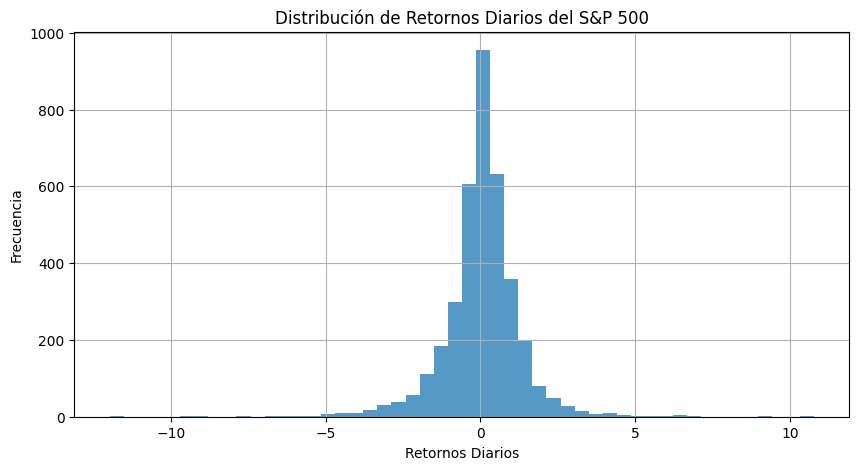

In [105]:
# Crear el histograma de los retornos diarios
plt.figure(figsize=[10,5])
plt.hist(datos_sp500['Daily Returns'].dropna(), bins=50, alpha=0.75)
plt.title('Distribución de Retornos Diarios del S&P 500')
plt.xlabel('Retornos Diarios')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

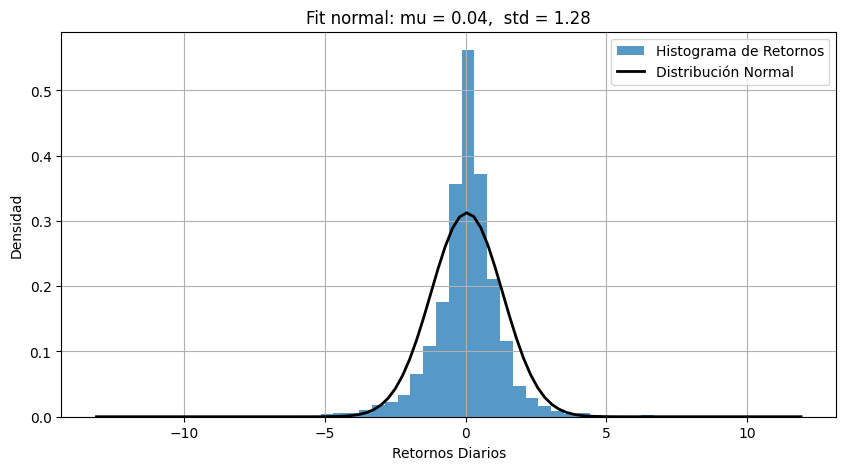

In [106]:
# Asumiendo que datos_sp500_2 es tu DataFrame y que tiene una columna 'Daily Returns'
# Elimina cualquier NaN para asegurar que la visualización y los cálculos se realicen correctamente
daily_returns = datos_sp500['Daily Returns'].dropna()

# Crear el histograma de los retornos diarios
plt.figure(figsize=[10, 5])
# Histograma de los retornos
count, bins, ignored = plt.hist(daily_returns, bins=50, alpha=0.75, density=True, label='Histograma de Retornos')

# Ajustar y superponer una distribución normal sobre el histograma
mu, std = stats.norm.fit(daily_returns)  # Calcula la media y la desviación estándar de los datos
xmin, xmax = plt.xlim()  # Obtener los límites del eje x del histograma para el plot de la normal
x = np.linspace(xmin, xmax, 100)  # Genera puntos x entre los límites de x, con igual espacio
p = stats.norm.pdf(x, mu, std)  # Calcula la densidad de la distribución normal en estos puntos

# Dibujar la curva de la distribución normal
plt.plot(x, p, 'k', linewidth=2, label='Distribución Normal')

title = "Fit normal: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Retornos Diarios')
plt.ylabel('Densidad')
plt.grid(True)
plt.legend()  # Añade una leyenda para identificar el histograma y la curva normal

# Mostrar el gráfico
plt.show()


In [107]:
# Calcula las estadísticas descriptivas
descriptivas = datos_sp500['Daily Returns'].describe()

# Añade el número de observaciones (excluyendo NaN)
descriptivas['count'] = datos_sp500['Daily Returns'].dropna().count()

# Calcula el rango intercuartilico para identificar atípicos
IQR = descriptivas['75%'] - descriptivas['25%']
lower_bound = descriptivas['25%'] - 1.5 * IQR
upper_bound = descriptivas['75%'] + 1.5 * IQR

# Encuentra los valores atípicos
outliers = datos_sp500[(datos_sp500['Daily Returns'] < lower_bound) | (datos_sp500['Daily Returns'] > upper_bound)]['Daily Returns']
descriptivas['outliers'] = len(outliers)

# Crear DataFrame para la tabla
tabla_descriptiva = pd.DataFrame(descriptivas).transpose()


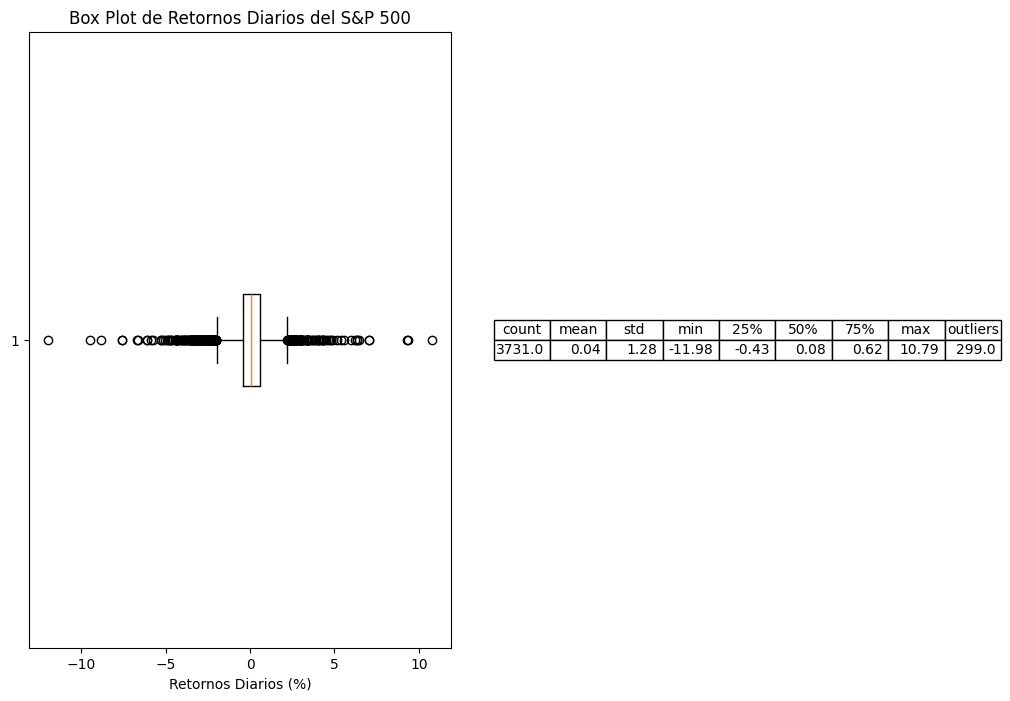

In [108]:
plt.figure(figsize=(12, 8))
plt.subplot(121)  # Posiciona el box plot en la izquierda
plt.boxplot(datos_sp500['Daily Returns'].dropna(), vert=False)
plt.title('Box Plot de Retornos Diarios del S&P 500')
plt.xlabel('Retornos Diarios (%)')

# Preparar los datos para la tabla, redondeando a dos decimales
tabla_descriptiva = tabla_descriptiva.round(2)

# Añadir una tabla con estadísticas al gráfico
plt.subplot(122)  # Posiciona la tabla en la derecha
plt.axis('tight')
plt.axis('off')
tabla_plot = plt.table(cellText=tabla_descriptiva.values,
                       colLabels=tabla_descriptiva.columns,
                       loc='center')
tabla_plot.auto_set_font_size(False)
tabla_plot.set_fontsize(10)
tabla_plot.scale(1.2, 1.2)  # Escala la tabla para que se ajuste mejor

# Mostrar el gráfico con la tabla
plt.show()



ANALISIS ESPECTRAL (TRANSFORMADA DE FOURIER)


La transformada de Fourier es un concepto matemático utilizado para transformar señales del dominio del tiempo (donde cada señal tiene un valor en cada instante de tiempo) al dominio de la frecuencia (donde cada señal se describe como una combinación de frecuencias). Esto se hace para facilitar el análisis y procesamiento de la información contenida en la señal.

Explicación Sencilla:
Imagina que tienes una canción. En el tiempo, se representa por cómo varía el sonido segundo a segundo. Pero si la descomponemos con la transformada de Fourier, lo que obtenemos es información sobre los distintos tonos musicales (frecuencias) que componen la canción. En lugar de saber qué ocurre en cada segundo, sabemos qué notas están presentes y cuán fuertes son.

¿Por qué se utiliza en el análisis de series de tiempo?
Descubrir Patrones Ocultos: En el análisis de series de tiempo, como datos financieros, meteorológicos, o señales de audio, es útil entender los ciclos o tendencias repetitivas. La transformada de Fourier ayuda a identificar estos patrones al revelar las frecuencias dominantes de los datos.
Filtrado de Datos: Permite separar componentes útiles de ruido. Por ejemplo, en telecomunicaciones, puede ayudar a eliminar el ruido de una señal para mejorar la claridad de la transmisión.
Compresión de Datos: En el ámbito de procesamiento de imágenes y señales de audio, la transformada de Fourier puede usarse para reducir el tamaño de los archivos, conservando las frecuencias más importantes y descartando las menos significativas.
Predicción y Análisis: Conocer las componentes frecuenciales de una serie de tiempo puede ayudar a construir modelos para predecir comportamientos futuros o para realizar análisis más profundos sobre la estabilidad o volatilidad de la serie observada.
En resumen, la transformada de Fourier convierte los datos del tiempo al dominio de frecuencia, proporcionando una nueva perspectiva que es a menudo más útil para el análisis y procesamiento de las series de tiempo.

In [109]:
# Calcula la transformada de Fourier para la columna 'Close'
fft_close = np.fft.fft(datos_sp500['Close'].dropna())

# Calcula la transformada de Fourier para la columna 'Daily Returns'
fft_returns = np.fft.fft(datos_sp500['Daily Returns'].dropna())


In [110]:
# Número de puntos en 'Close'
n_close = len(fft_close)

# Número de puntos en 'Daily Returns'
n_returns = len(fft_returns)

# Frecuencia de muestreo (suponemos que los datos son diarios)
# Obtener frecuencias para cada punto (asumimos datos diarios, por lo que la unidad es días)
frequencies_close = np.fft.fftfreq(n_close)

frequencies_returns = np.fft.fftfreq(n_returns)


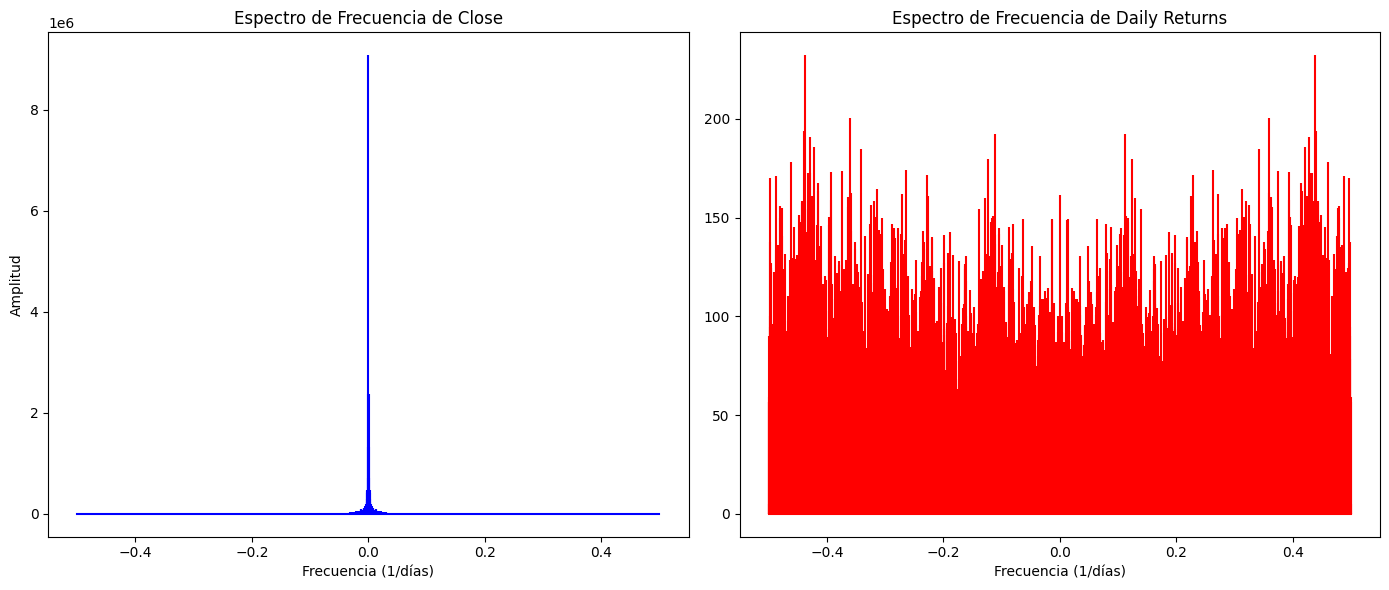

In [111]:
# Grafica la magnitud de la transformada de Fourier para 'Close'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # Primer subgráfico
plt.stem(frequencies_close, np.abs(fft_close), 'b', markerfmt=" ", basefmt="-b")
plt.title('Espectro de Frecuencia de Close')
plt.xlabel('Frecuencia (1/días)')
plt.ylabel('Amplitud')

# Grafica la magnitud de la transformada de Fourier para 'Daily Returns'
plt.subplot(1, 2, 2)  # Segundo subgráfico
plt.stem(frequencies_returns, np.abs(fft_returns), 'r', markerfmt=" ", basefmt="-r")
plt.title('Espectro de Frecuencia de Daily Returns')
plt.xlabel('Frecuencia (1/días)')

# Mostrar gráfico
plt.tight_layout()
plt.show()


Los gráficos que has compartido muestran los espectros de frecuencia para las series de tiempo de los precios de cierre ('Close') y de los retornos diarios ('Daily Returns') del S&P 500. Aquí está cómo puedes interpretar cada uno de estos gráficos:

Espectro de Frecuencia de Close
Dominancia de Bajas Frecuencias: El gráfico de 'Close' muestra un pico muy pronunciado en la frecuencia cercana a cero. Esto indica que la serie de tiempo de los precios de cierre tiene una componente de baja frecuencia muy fuerte, lo que típicamente representa una tendencia subyacente o un movimiento a largo plazo en los datos. No hay muchas variaciones significativas a frecuencias más altas, lo que sugiere que los movimientos de precios no están compuestos por fluctuaciones rápidas o ciclos cortos.
Estabilidad: La presencia de una fuerte componente de baja frecuencia también sugiere estabilidad en el sentido de que los precios no cambian bruscamente de un día para otro, sino que siguen una tendencia más suave y gradual.
Espectro de Frecuencia de Daily Returns
Distribución de Frecuencias Más Amplia: A diferencia del gráfico de 'Close', el espectro de los 'Daily Returns' muestra una distribución mucho más amplia y variada de frecuencias con amplitudes significativas. Esto indica que los retornos diarios contienen una variedad de ciclos y fluctuaciones que ocurren a diferentes ritmos.
Volatilidad y Ruido: La presencia de picos a varias frecuencias, particularmente hacia frecuencias más altas, sugiere que los retornos diarios están influenciados por factores que inducen cambios más rápidos y pueden ser interpretados como mayor volatilidad o ruido en los retornos diarios. Esto es típico en los retornos de acciones, donde el "ruido" diario y las reacciones a eventos de noticias son más evidentes.
Falta de una Tendencia Claramente Definida: A diferencia de los precios de cierre, los retornos diarios no muestran un pico dominante en baja frecuencia, lo que implica que no hay una tendencia fuerte a largo plazo en los retornos diarios; más bien, están dominados por componentes de frecuencia más alta.
Conclusiones Generales
Comportamiento del Mercado: Mientras que los precios de cierre muestran una tendencia clara y son más predecibles a largo plazo debido a su fuerte componente de baja frecuencia, los retornos diarios son mucho más susceptibles a variaciones diarias y muestran una gama más amplia de comportamientos cíclicos.
Estrategias de Inversión: Para un inversionista, estos gráficos sugieren que las estrategias de inversión podrían necesitar considerar diferentes horizontes temporales y métodos de análisis: uno más centrado en la tendencia a largo plazo para los precios de cierre, y otro que maneje la volatilidad y el ruido para los retornos diarios.
Estos análisis de frecuencia proporcionan información valiosa para entender la naturaleza de los datos financieros y pueden ayudar a guiar decisiones basadas en el tipo de componentes frecuenciales presentes en los datos.

La gráfica que has compartido representa el espectro de frecuencia del S&P 500, obtenido a través de la transformada de Fourier aplicada a una serie de tiempo, posiblemente de precios diarios o retornos. Aquí te explico cómo interpretarla:

Eje Horizontal (Frecuencia): Muestra las frecuencias contenidas en los datos del S&P 500. Estas frecuencias se pueden interpretar como la inversa del período; por ejemplo, una frecuencia de 0.01 podría corresponder a un ciclo que se repite cada 100 días (1/0.01).
Eje Vertical (Potencia): Indica cuánta "potencia" o cuánta importancia tiene cada frecuencia en los datos. La potencia más alta sugiere que la señal contiene una gran cantidad de esa frecuencia específica.
Análisis de la Gráfica:
Pico en Frecuencias Bajas: El pico significativo muy cerca del origen (frecuencia casi 0) indica que hay una tendencia o un cambio muy lento en los datos, que domina la serie de tiempo. Esto podría representar tendencias a largo plazo en el mercado.
Decaimiento de la Potencia: A medida que aumenta la frecuencia, la potencia disminuye rápidamente, lo que indica que las fluctuaciones de alta frecuencia (cambios rápidos y frecuentes en los precios) tienen mucho menos impacto en la estructura general de los datos comparado con las tendencias a largo plazo.
Implicaciones:
Análisis de Inversiones: Los inversores a largo plazo podrían estar más interesados en las frecuencias más bajas, ya que estas reflejan las tendencias más sostenibles en el tiempo.
Modelado y Predicción: Modelos que intentan capturar o predecir tendencias a largo plazo pueden necesitar concentrarse en las frecuencias más bajas, mientras que para estrategias de trading de alta frecuencia, las frecuencias más altas podrían ser más relevantes, aunque aquí parecen tener poca potencia.
Esta interpretación ayuda a entender cómo se comporta el mercado en diferentes escalas de tiempo, facilitando decisiones basadas en el comportamiento y la volatilidad del mercado subyacente.

Es un random walk?

1. Prueba de Raíces Unitarias
Una de las pruebas más comunes para determinar si una serie temporal es un random walk es la prueba de Dickey-Fuller aumentada. Esta prueba verifica la presencia de una raíz unitaria, que es una característica de los procesos de random walk.

Estadístico de Prueba (ADF Statistic): Si es menor que los valores críticos, rechaza la hipótesis nula de raíz unitaria (no es un random walk).
p-value: Un p-value bajo (generalmente < 0.05) indica que puedes rechazar la hipótesis nula de que la serie es un random walk.

In [112]:
import statsmodels.api as sm

# Asumiendo que datos_sp500['Daily Returns'] ya está definido
# Primero, elimina cualquier NaN para asegurar que la prueba funcione correctamente
daily_returns = datos_sp500['Daily Returns'].dropna()

# Realizar la prueba de Dickey-Fuller aumentada
result = sm.tsa.adfuller(daily_returns)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


ADF Statistic: -11.32429634528218
p-value: 1.153639466414822e-20
Critical Values: {'1%': -3.4321186060970326, '5%': -2.862321472229483, '10%': -2.567185988970051}


2. Análisis de Autocorrelación
Un random walk debería mostrar una autocorrelación significativa solo en el primer desfase (lag) y ninguna autocorrelación significativa en los desfases mayores.
Interpretación: En un random walk, esperarías ver una fuerte autocorrelación en el primer lag y una rápida disminución a medida que aumentan los lags. Si ves autocorrelaciones significativas en lags mayores, eso sugiere que no es un random walk.

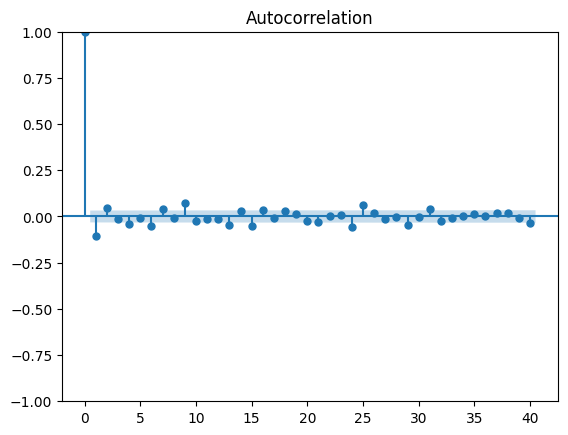

In [113]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Graficar la función de autocorrelación
plot_acf(daily_returns, lags=40)
plt.show()


3. Volatilidad de los Retornos
Si los retornos son un random walk, su distribución debería ser consistente a lo largo del tiempo. Cualquier cambio significativo en la volatilidad podría sugerir que no es un random walk.
Interpretación: Variaciones significativas en la volatilidad podrían indicar que los retornos no siguen un random walk.

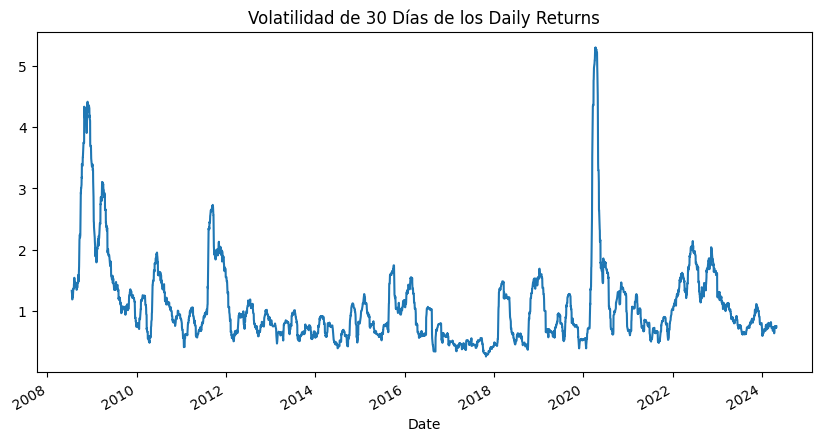

In [114]:
# Calcular la volatilidad móvil de los retornos diarios (ejemplo: ventana de 30 días)
daily_returns['Volatility'] = daily_returns.rolling(window=30).std()

# Graficar la volatilidad
daily_returns['Volatility'].plot(figsize=(10, 5))
plt.title('Volatilidad de 30 Días de los Daily Returns')
plt.show()


Los gráficos y resultados estadísticos que has proporcionado ofrecen una perspectiva detallada sobre el comportamiento de los retornos diarios del S&P 500. Aquí está cómo interpretar los resultados en conjunto:

1. Prueba de Dickey-Fuller Aumentada (ADF)
Estadístico de Prueba: -11.3243, que es mucho menor que los valores críticos a los niveles de significancia del 1%, 5% y 10%. Esto sugiere un rechazo muy fuerte de la hipótesis nula de que existe una raíz unitaria.
p-value: 1.15e-20, un valor extremadamente bajo, confirma el rechazo de la hipótesis nula. Esto indica que la serie de tiempo de los retornos diarios no es un random walk.
2. Gráfico de Autocorrelación
Observación de la Autocorrelación: Hay una autocorrelación significativa en el primer lag y luego disminuye rápidamente hacia cero o incluso se vuelve negativa en lags posteriores. Este patrón es típico de una serie que ha sido diferenciada para lograr la estacionariedad y no es indicativo de un random walk, ya que en un random walk esperaríamos ver una persistencia mucho más significativa en la autocorrelación.
3. Gráfico de Volatilidad de 30 Días
Observaciones de Volatilidad: La volatilidad no es constante a lo largo del tiempo; presenta picos significativos, especialmente en torno a eventos específicos (como la crisis financiera de 2008 y la pandemia de COVID-19 en 2020). La variabilidad en la volatilidad sugiere que hay factores exógenos afectando los retornos y que la volatilidad de los retornos puede ser modelada más efectivamente por modelos que permiten cambios en la varianza a lo largo del tiempo, como los modelos GARCH, más que asumir un simple random walk.
Interpretación Conjunta:
No Random Walk: Todos estos indicadores juntos sugieren fuertemente que los retornos diarios del S&P 500 no siguen un random walk. En su lugar, parecen ser estacionarios con cambios significativos en la volatilidad, lo que podría ser capturado por modelos más sofisticados que solo un simple modelo de caminata aleatoria.
Importancia de Modelos de Volatilidad: Dada la variabilidad evidente en la volatilidad a lo largo del tiempo, modelos que pueden adaptarse a volatilidades cambiantes (como los modelos GARCH) pueden ser más adecuados para describir y predecir los retornos del S&P 500.
Implicaciones para el Trading y la Gestión de Riesgos: La fuerte autocorrelación inicial y la variabilidad en la volatilidad pueden ser explotadas para estrategias de trading y deberían ser consideradas en la gestión del riesgo.
En conclusión, los retornos diarios del S&P 500 muestran características de estacionariedad, no consistencia con un random walk, y una variabilidad significativa en la volatilidad, lo que sugiere que el comportamiento del mercado puede ser influenciado por factores estructurales y eventos de mercado.








CORRELACIONES

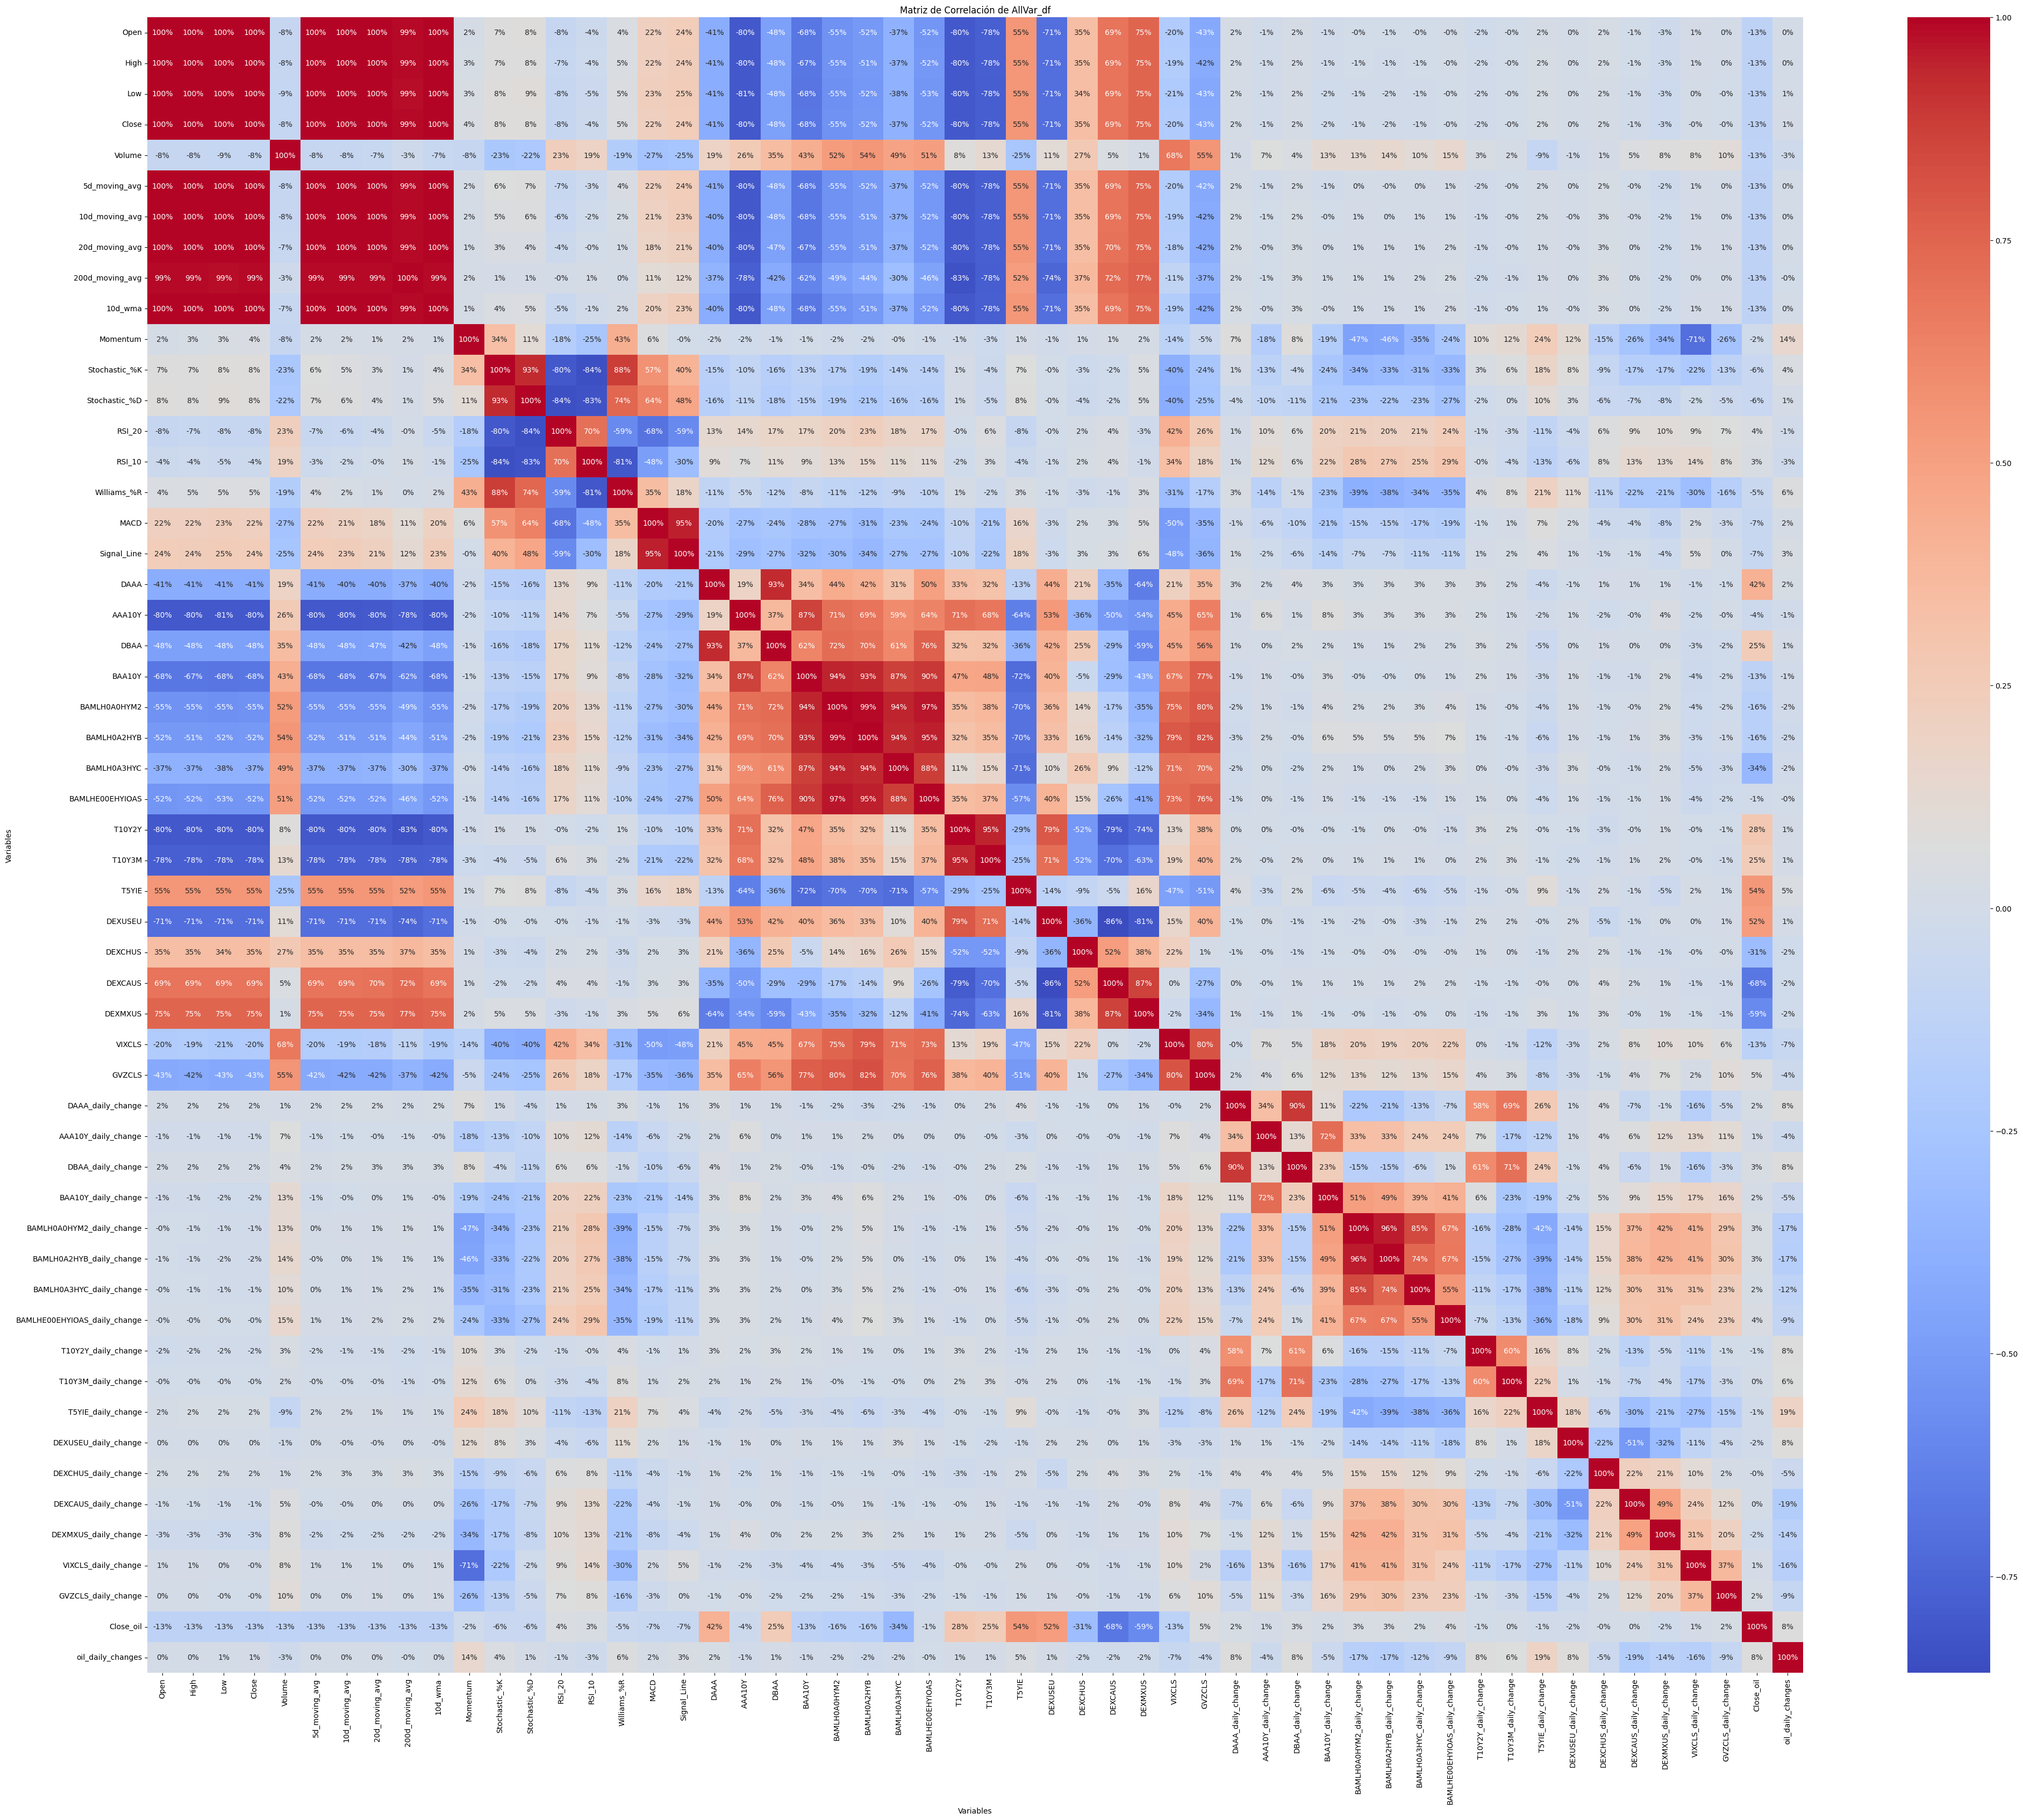

In [116]:
import seaborn as sns


# Suponemos que AllVar_df es tu DataFrame y ya está definido
# Calcular la matriz de correlación
corr_matrix = AllVar_df.corr()

# Crear el heatmap usando seaborn
plt.figure(figsize=(50, 40))  # Ajusta el tamaño del gráfico según necesites
sns.heatmap(corr_matrix, annot=True, fmt=".0%", cmap='coolwarm', cbar=True, square=True)

# Añadir títulos y etiquetas si es necesario
plt.title('Matriz de Correlación de AllVar_df')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Mostrar el gráfico
plt.show()


In [118]:
print(corr_matrix)

                                  Open      High       Low     Close  \
Open                          1.000000  0.999916  0.999872  0.999778   
High                          0.999916  1.000000  0.999828  0.999878   
Low                           0.999872  0.999828  1.000000  0.999897   
Close                         0.999778  0.999878  0.999897  1.000000   
Volume                       -0.081486 -0.077530 -0.087718 -0.083002   
5d_moving_avg                 0.999800  0.999787  0.999637  0.999645   
10d_moving_avg                0.999402  0.999453  0.999123  0.999203   
20d_moving_avg                0.998512  0.998683  0.998083  0.998295   
200d_moving_avg               0.986312  0.987101  0.985317  0.986167   
10d_wma                       0.998960  0.999042  0.998606  0.998724   
Momentum                      0.018156  0.026226  0.029466  0.037353   
Stochastic_%K                 0.072267  0.071388  0.080306  0.079316   
Stochastic_%D                 0.079786  0.076506  0.085442  0.08

Análisis General de la Matriz de Correlación
Correlaciones entre Precios de Apertura, Cierre, Máximo y Mínimo:
Variables ('Open', 'High', 'Low', 'Close'): Estas variables están extremadamente correlacionadas entre sí con valores cercanos a 1. Esto indica que cualquier variable de esta serie puede representar efectivamente a las otras en términos de captura de información sobre el precio del activo en modelos de predicción.

Correlaciones con Medias Móviles:
Variables ('5d_moving_avg', '10d_moving_avg', '20d_moving_avg'): Estas también muestran alta correlación con 'Open', 'High', 'Low', 'Close'. En escenarios de modelado, especialmente para evitar la multicolinealidad en modelos como la regresión logística, podrías optar por utilizar solo una de estas medias móviles o los precios directamente.

Variables de Volumen y Volatilidad:
'Volume' y 'VIXCLS': El volumen y el índice de volatilidad muestran una correlación moderada negativa con los precios, lo que sugiere que podrían ofrecer información adicional útil que no está directamente correlacionada con los movimientos de los precios.

Indicadores Técnicos:
Variables como 'RSI', 'MACD', 'Stochastic_%K/D', 'Williams_%R': Estos indicadores técnicos muestran correlaciones bajas a moderadas con los precios, indicando que también podrían ser útiles en los modelos para capturar aspectos del comportamiento del precio no directamente relacionados con los precios simples.
Variables Económicas:
'DEXUSEU', 'DEXCHUS', 'DEXCAUS', 'DEXMXUS': Estas tasas de cambio tienen correlaciones negativas con variables como 'AAA10Y', 'BAA10Y', lo que podría indicar una oportunidad para explorar relaciones económicas más profundas en modelos más complejos como LSTM.

Recomendaciones para la Selección de Variables
Evitar Redundancia:
Dada la alta correlación entre varias de las series de precios y medias móviles, considera utilizar solo una representación de cada grupo (por ejemplo, usar 'Close' o '20d_moving_avg' pero no ambas).

Incluir Diversidad:
Incluye variables que están menos correlacionadas entre sí para proporcionar una vista más holística del comportamiento del mercado, como combinar 'Close' con 'Volume' y 'VIXCLS'.
Exploración de Indicadores Técnicos:
Considera incluir indicadores técnicos que ofrecen diferentes perspectivas que no están altamente correlacionadas con los precios directos.

Modelos Específicos:
Para modelos como RandomForest y LSTM, que pueden manejar una mayor dimensionalidad y complejidad, podrías incluir un conjunto más amplio de variables y luego utilizar técnicas de importancia de características para afinar el modelo.

En regresión logística, enfócate en evitar la multicolinealidad para mejorar la estabilidad y la interpretabilidad del modelo.
Consideraciones Finales

Validación: Siempre valida el impacto de la selección de variables mediante validación cruzada y ajuste de hiperparámetros.









